# Time series demo

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs

%matplotlib inline

In [2]:
with open("pkl_files/df1_rain_dum.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [3]:
# limit years and set to one district
df = df[df.year >= 1950]
df = df[df.district == 'Adilabad']
df = df[['state', 'district', 'dt', 'avg_temp', 'rainfall']]

In [4]:
df.sort_values('dt', inplace = True)

In [5]:
df['index'] = df.dt
df.set_index(['index'], inplace=True)
df.index.name=None

In [6]:
df.head()

,state,district,dt,avg_temp,rainfall
1950-01-01,Andhra Pradesh,Adilabad,1950-01-01,17.126788,0.000
1950-02-01,Andhra Pradesh,Adilabad,1950-02-01,17.706273,19.575
1950-03-01,Andhra Pradesh,Adilabad,1950-03-01,23.502788,11.781
1950-04-01,Andhra Pradesh,Adilabad,1950-04-01,29.129242,0.185
1950-05-01,Andhra Pradesh,Adilabad,1950-05-01,33.717758,13.459


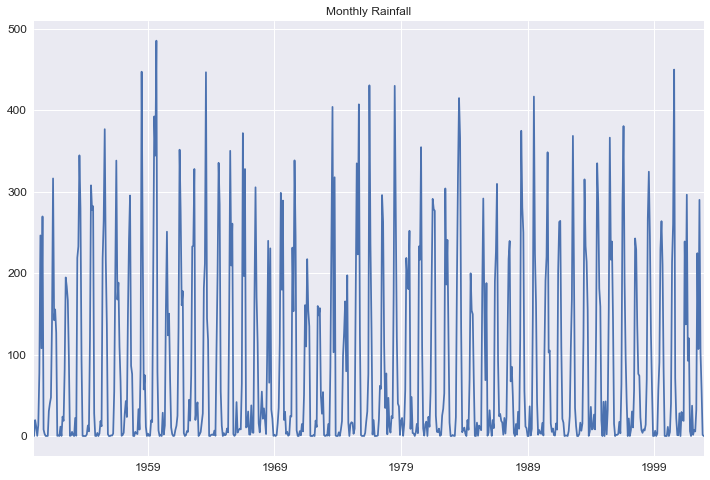

In [7]:
df.rainfall.plot(figsize=(12,8), title= 'Monthly Rainfall', fontsize=12);

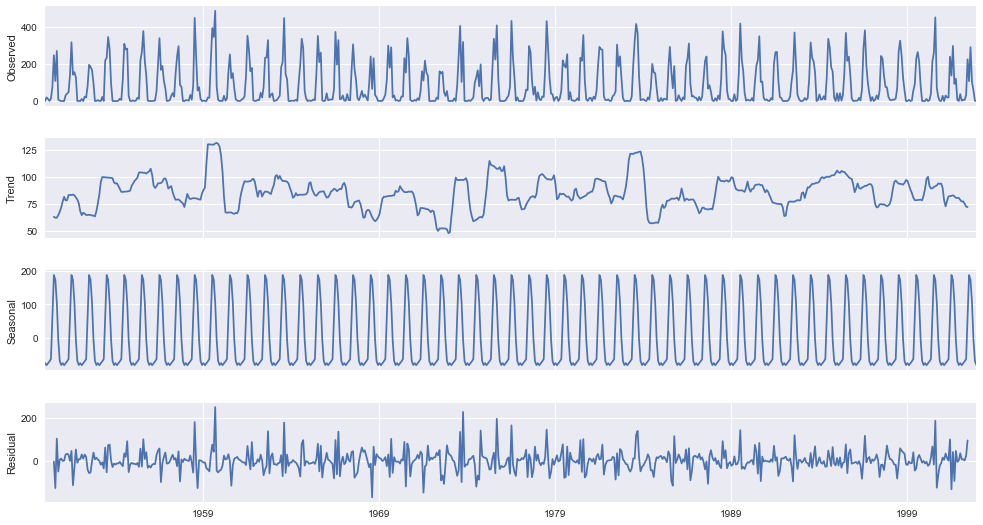

In [8]:
decomposition = seasonal_decompose(df.rainfall, freq=12)  
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [9]:
plt.style.use('fivethirtyeight')

## search for best parameters

**p** is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.  
**d** is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.  
**q** is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.  

In [10]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

#run overnight with 
#p = d = q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf 
best_param = None
best_seasonal = None
best_mod = None


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_mod = sm.tsa.statespace.SARIMAX(df.rainfall,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = temp_mod.fit()
           
            
            temp_aic = results.aic
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_param = param
                best_seasonal = param_seasonal
                best_mod = temp_mod
                
        except:
            continue
            
            #results = mod.fit()

print('Best model: ARIMA{}x{}12 - AIC:{}'.format(best_param, best_seasonal, best_aic))

Best model: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:6595.388532546656


## run model and diagnostics

In [12]:
mod = sm.tsa.statespace.SARIMAX(df.rainfall,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9050      0.067    -13.470      0.000      -1.037      -0.773
ma.L1          0.8643      0.077     11.165      0.000       0.713       1.016
ma.S.L12      -1.0391      0.023    -45.519      0.000      -1.084      -0.994
sigma2      2554.1033    111.239     22.960      0.000    2336.078    2772.129


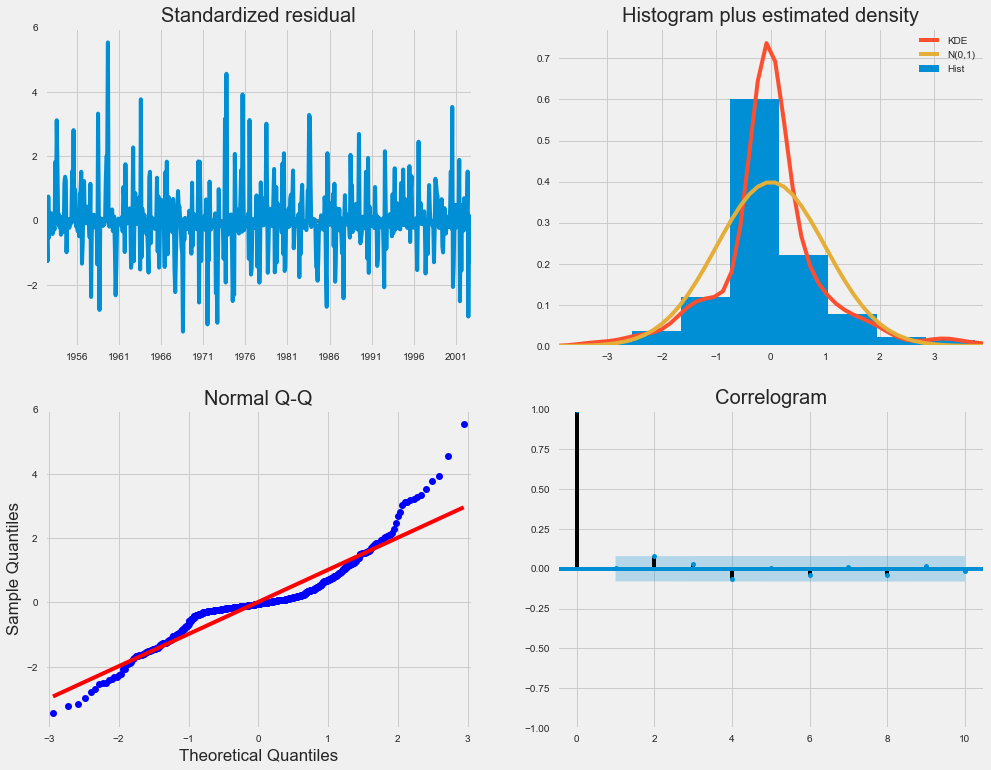

In [13]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## generate predictions

**One step ahead**

In [14]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

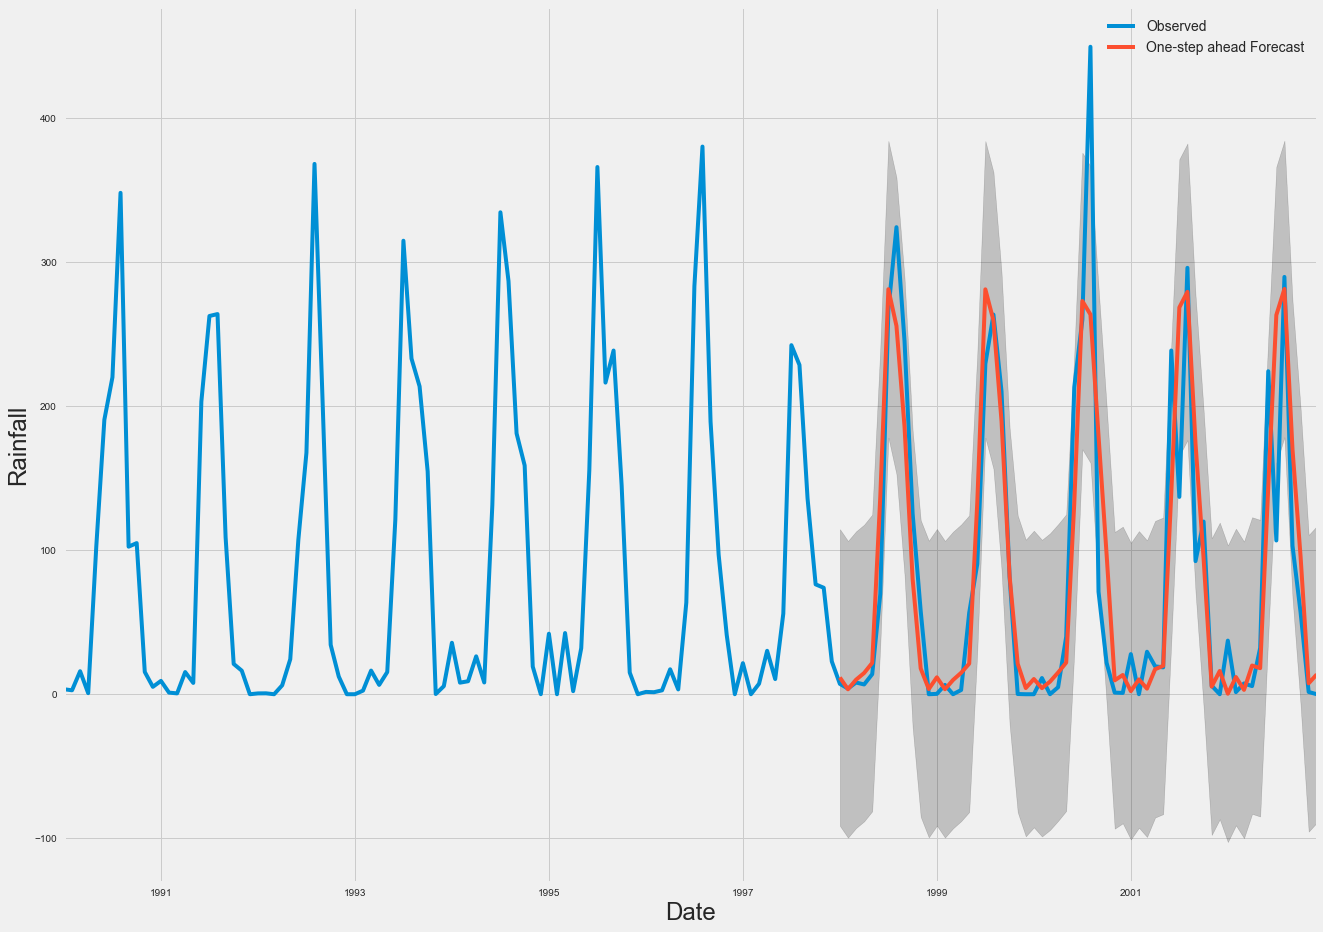

In [15]:
ax = df.rainfall['1990':].plot(label='Observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date', fontsize = 24)
ax.set_ylabel('Rainfall', fontsize = 24)
plt.legend(fontsize = 14)

plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = df.rainfall['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2650.13


**Dynamic predictions**

In [17]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

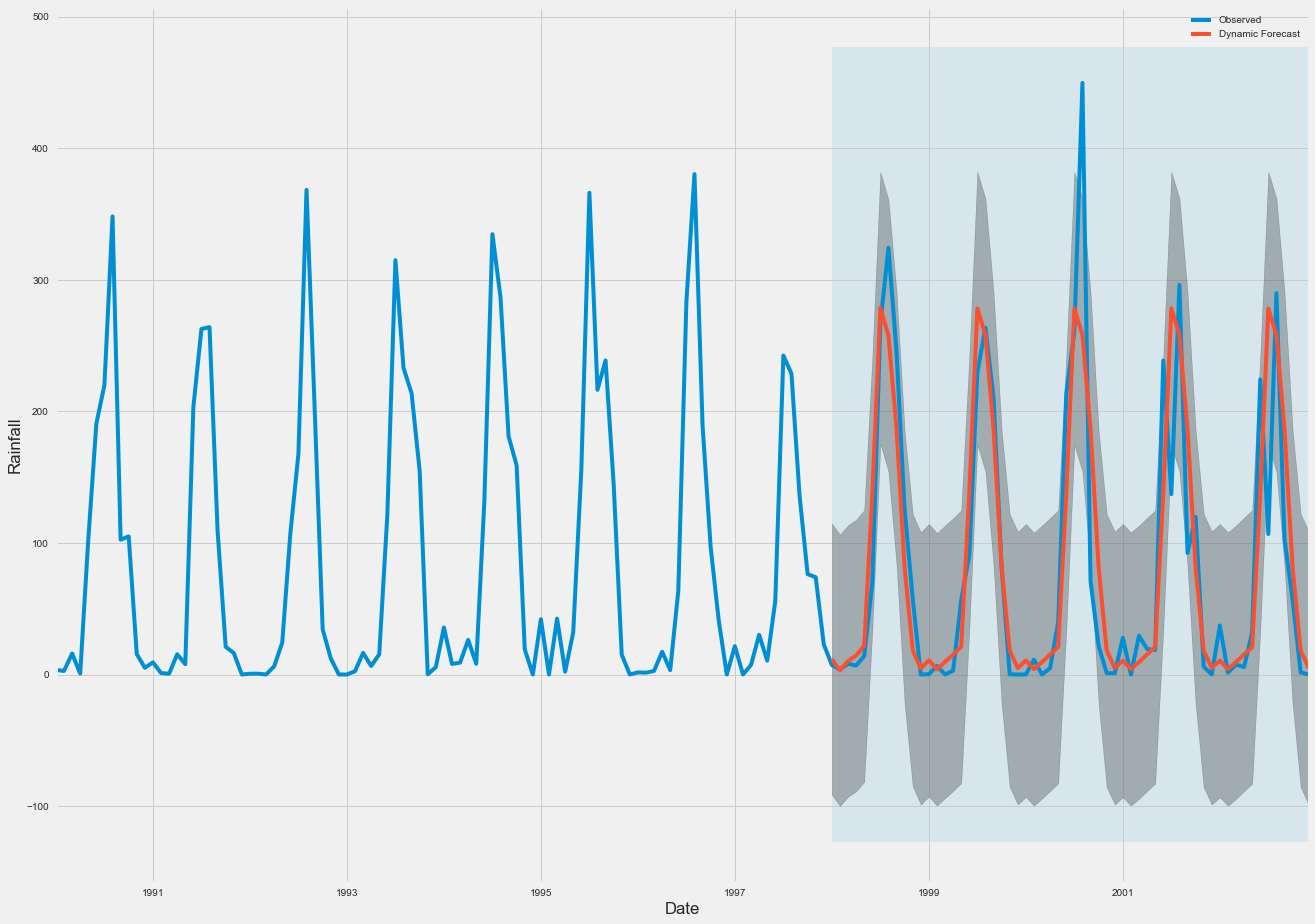

In [18]:
ax = df.rainfall['1990':].plot(label='Observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')

plt.legend()
plt.show()

In [19]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = df.rainfall['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2892.43


In [20]:
# Get forecast 10 years ahead in future
pred_uc = results.get_forecast(steps=120)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

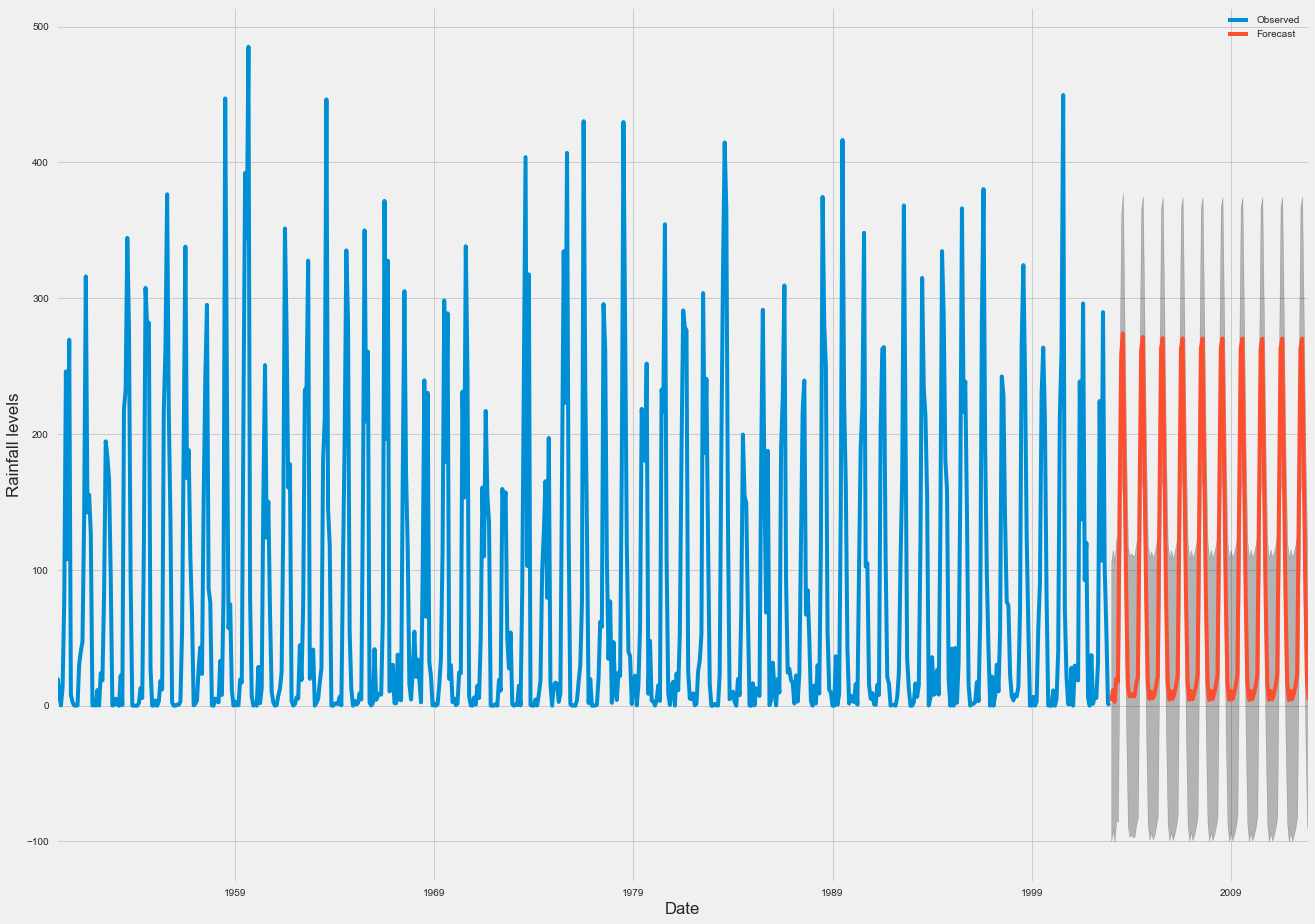

In [21]:
ax = df.rainfall.plot(label='Observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall levels')

plt.legend()
plt.show()